# Random Forest from Scratch

comparision of custom vs sklearn based model

# 1-Importing key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
import string
import math
import numpy as np
import pandas as pd
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
# Modules imported from .py files(decision tree & helper functions ) 
import random
from pprint import pprint
import decision_tree_functions
import helper_functions

from decision_tree_functions import decision_tree_algorithm, decision_tree_predictions
from helper_functions import train_test_split, calculate_accuracy

# 2- Load Data

In [4]:
df = pd.read_csv("winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# since quality is our target variable
df["label"] = df.quality
df = df.drop("quality", axis=1)

column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.shape

(1599, 12)

In [7]:
df.label.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: label, dtype: int64

10 being highest and 1 being lowest

In [8]:
df.label.value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: label, dtype: float64

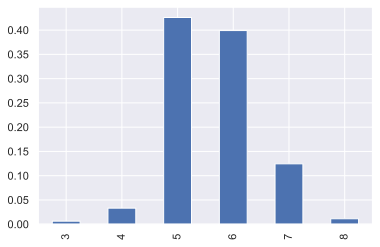

In [9]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality = wine_quality.sort_index()
wine_quality.plot(kind="bar")

In [10]:
def transform_label(value):
    if value <= 5:
        return "bad"
    else:
        return "good"

df["label"] = df.label.apply(transform_label)

In [11]:
df.label.value_counts()

good    855
bad     744
Name: label, dtype: int64

In [12]:
df.label.value_counts(normalize=True)

good    0.534709
bad     0.465291
Name: label, dtype: float64

good    0.534709
bad     0.465291
Name: label, dtype: float64

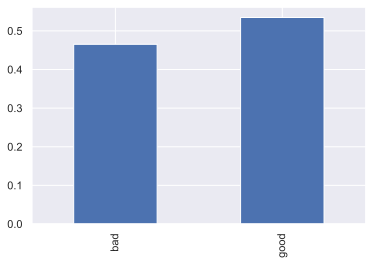

In [13]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality[["bad", "good"]].plot(kind="bar")
wine_quality

we have a binary problem now.

In [14]:
#train-test split
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

# 3- Random Forest Algorithm

In [15]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

- **bootstrap** is for randomly choosing samples. Some samples can even occur multiple times as it is random selection.In our case we shall choose 800 out of 1599 almost half of overall data samples
- **Random subspace**(added in decision tree) is random selection of features i.e our columns. So n_feature represents random sub-space.Hence, both rows and columns are now shuffled randomly.
- **number of trees** (added in random_forest_algorithm function) are trees that are made from above random rows and columns. We shall make 4 trees composed of random rows and random columns.
- **max_depth** is the depth to which trees will make layers. For example , 4 layers mean a hiearchy of 4 steps/levels down the way till a classification output is finalized.


all these parameters have come after testing and checking best accuracy score with multiple combination. Scikit learn provides these best parameters after "Model Tune".<br>
Following is combination of trees creating a random forest.


In [16]:
forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=2, dt_max_depth=4)

In [17]:
pprint(forest[0])

{'pH <= 3.16': [{'volatile_acidity <= 0.35': [{'chlorides <= 0.07400000000000001': ['good',
                                                                                    {'alcohol <= 9.7': ['good',
                                                                                                        'bad']}]},
                                              'bad']},
                {'sulphates <= 0.68': [{'sulphates <= 0.52': [{'alcohol <= 11.1': ['bad',
                                                                                   'good']},
                                                              {'density <= 0.99622': ['good',
                                                                                      'bad']}]},
                                       'good']}]}


In [18]:
pprint(forest[1])

{'sulphates <= 0.62': [{'chlorides <= 0.069': [{'alcohol <= 9.6': [{'chlorides <= 0.068': ['bad',
                                                                                           'good']},
                                                                   'good']},
                                               'bad']},
                       {'alcohol <= 9.95': [{'chlorides <= 0.084': [{'free_sulfur_dioxide <= 4.0': ['bad',
                                                                                                    'good']},
                                                                    'bad']},
                                            {'volatile_acidity <= 0.635': ['good',
                                                                           {'fixed_acidity <= 9.6': ['good',
                                                                                                     'bad']}]}]}]}


In [19]:
pprint(forest[2])

{'citric_acid <= 0.29': [{'chlorides <= 0.044': ['good',
                                                 {'total_sulfur_dioxide <= 94.0': ['bad',
                                                                                   {'volatile_acidity <= 0.49': ['good',
                                                                                                                 'bad']}]}]},
                         {'density <= 0.99677': [{'density <= 0.9956': ['good',
                                                                        {'volatile_acidity <= 0.59': ['good',
                                                                                                      'bad']}]},
                                                 {'total_sulfur_dioxide <= 103.0': ['good',
                                                                                    'bad']}]}]}


In [20]:
pprint(forest[3])

{'citric_acid <= 0.26': [{'sulphates <= 0.57': [{'volatile_acidity <= 0.36': ['good',
                                                                              {'alcohol <= 11.1': ['bad',
                                                                                                   'good']}]},
                                                {'alcohol <= 9.8': ['bad',
                                                                    'good']}]},
                         {'total_sulfur_dioxide <= 67.0': [{'chlorides <= 0.358': ['good',
                                                                                   'bad']},
                                                           {'residual_sugar <= 7.5': ['bad',
                                                                                      'good']}]}]}


In [21]:
df_predictions = {}
for i in range(len(forest)):
    column_name = "tree_{}".format(i)
    predictions = decision_tree_predictions(test_df , tree=forest[i])
    df_predictions[column_name]=predictions
    
df_predictions=pd.DataFrame(df_predictions)

In [22]:
df_predictions.head()

,tree_0,tree_1,tree_2,tree_3
788,bad,bad,bad,bad
1552,good,good,bad,good
861,good,good,good,bad
82,bad,bad,good,bad
530,good,good,bad,good


There we have 4 trees with output results. 

- For 788,voting will be made and final output for this example is 'good' 

In [23]:
df_predictions = {}
for i in range(len(forest)):
    column_name = "tree_{}".format(i)
    predictions = decision_tree_predictions(test_df , tree=forest[i])
    df_predictions[column_name]=predictions
    
df_predictions=pd.DataFrame(df_predictions)
random_forest_predictions=df_predictions.mode(axis=1)[0]

In [24]:
random_forest_predictions

788      bad
1552    good
861     good
82       bad
530     good
        ... 
562      bad
927      bad
525      bad
273      bad
1338     bad
Name: 0, Length: 320, dtype: object

In [27]:
accuracy = calculate_accuracy(predictions, test_df.label)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.715625


##### All in one quick pattern

In [ ]:
forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=2, dt_max_depth=4)
predictions = random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.label)

print("Accuracy = {}".format(accuracy))

# 4-Using sklearn

In [28]:
# since quality is our target variable
data = pd.read_csv("winequality-red.csv")
data["target"] = data.quality
data = data.drop("quality", axis=1)

column_names = []
for column in data.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
data.columns = column_names
print(data.target.value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: target, dtype: int64


In [29]:
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [30]:
#Function for category id
data['category_id'] = data['target'].factorize()[0]
category_id_df = data[['target', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'target']].values)
data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,target,category_id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


In [31]:
y=data['target']
X= data.drop(['target'], axis=1)
print(X.shape)
print(y.shape)

(1599, 12)
(1599,)


In [32]:
# splitting data into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1279, 12)
(320, 12)
(1279,)
(320,)


In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_pred, y_test)

0.984375

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.91      0.95        11
           5       1.00      1.00      1.00       130
           6       1.00      1.00      1.00       132
           7       1.00      0.91      0.95        46
           8       0.20      1.00      0.33         1

    accuracy                           0.98       320
   macro avg       0.70      0.80      0.71       320
weighted avg       1.00      0.98      0.99       320



In [36]:
print(confusion_matrix(y_pred, y_test))

[[  0   0   0   0   0   0]
 [  1  10   0   0   0   0]
 [  0   0 130   0   0   0]
 [  0   0   0 132   0   0]
 [  0   0   0   0  42   4]
 [  0   0   0   0   0   1]]


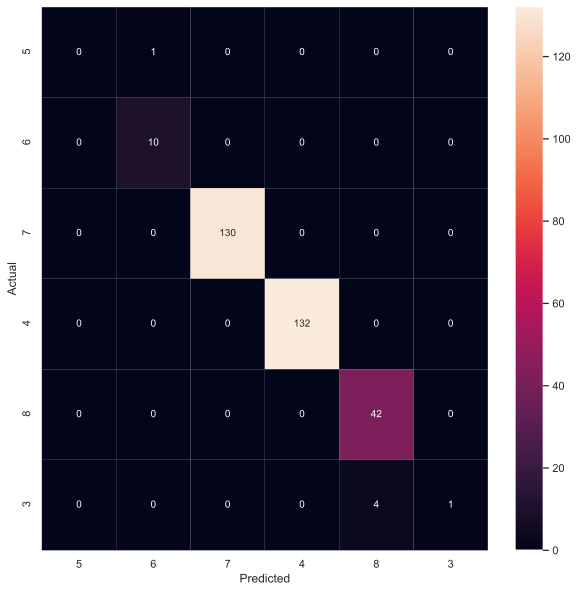

In [37]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.target.values, yticklabels=category_id_df.target.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 5- Comparing mean accuracy value

custom model vs sklearn model

### 5a. Custom model for decision tree algorithm

In [38]:
# for decision tree, we only use tree=1
accuracies=[]
for i in range(10):
    forest=random_forest_algorithm(train_df, n_trees=1,n_bootstrap=len(train_df), n_features=999, dt_max_depth=4)
    predictions=calculate_accuracy(predictions, test_df.label)
    print(accuracy)
    accuracies.append(accuracy)
    
print("Mean Accuracy: {}".format(np.array(accuracies).mean()))

0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
Mean Accuracy: 0.715625


### 5b.custome model for random forest algorithm

In [39]:
# for random forest
accuracies=[]
for i in range(10):
    forest=random_forest_algorithm(train_df, n_trees=4,n_bootstrap=800, n_features=4, dt_max_depth=4)
    predictions=calculate_accuracy(predictions, test_df.label)
    print(accuracy)
    accuracies.append(accuracy)
    
print("Mean Accuracy: {}".format(np.array(accuracies).mean()))

0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
0.715625
Mean Accuracy: 0.715625


### 5c. Sklearn model using cross validation

In [40]:
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),   
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [41]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.834375
1,RandomForestClassifier,1,0.887500
2,RandomForestClassifier,2,0.881250
3,RandomForestClassifier,3,0.893750
4,RandomForestClassifier,4,0.884013


In [42]:
cv_df.groupby('model_name').accuracy.mean()

model_name
RandomForestClassifier    0.876178
Name: accuracy, dtype: float64

**Conclusion:**

- It is good to know coding and everything from scratch. However, sklearn modules performs pretty well for traditional models such as Decision Tree, SVM, KNN, Random Forest.
- Therefore, we get a more consistent, reliable and well performing model with sklearn